# 5. Data Augmentation

- [x] Run at least one experiment with an augmented dataset that includes additional data selected based on training data perplexity under a language model trained the task you’ve selected.

In [ ]:

import pandas as pd
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,classification_report
import sys
sys.path.insert(0, '/work/twitter-nlp')
from boilerplate import load_and_tokenize, pickling, open_jar, func_regex
import numpy as np

## Labeling Trumps Twitter Insults
We took Trumps insults (provided by the New York Times) and combined those with all his other tweets.  <br>
>https://www.nytimes.com/interactive/2021/01/19/upshot/trump-complete-insult-list.html <br>
>https://www.thetrumparchive.com/faq (all Tweets from 2009 to 2020)

The idea behind this was also that Trump tweets would be very similiar to the data, which our model had been trained on. <br>
The most frequent unique keywords throughout the hatespeech dataset were: 
> _migrant, refugee, #buildthatwall, bitch, hoe, women_
These keywords are quite relevant when you look at Donald Trump's presidency, and since all the data was collected during the period of July to September 2018 and, Trump's insult tweet/_normal_ tweet dataset also included tweets from this time period, we hoped to get quite accurate and interesting results.

In [ ]:
# loading in trump's twitter insults
# the insult data is a collection of all insults from 2015 to 2021 (until trump was banned)
insult_data = pd.read_csv("/work/twitter-nlp/data/trumptwitterinsults/trump_insult_tweets_2014_to_2021.csv")

# only using the tokens data, and dropping all duplicates, adding a hatespeech label (all are marked as hatespeech)
tweets = insult_data["tweet"]
tweets = tweets.drop_duplicates()
insult_tokens = pd.DataFrame(columns=["Labels", "Tweets"])
insult_tokens["Tweets"] = tweets
insult_tokens["Labels"] = [1 for _ in range(0, len(insult_tokens))]

We combined these with a collection of all of his tweets from 2009 to 2020, dropping duplicates, and labelling all insult tweets as 1, and the rest 0. <br>


In [ ]:
# the standard data is a collection of all of trumps tweets from 2009 to 2021 (until trump was banned)
standard_data = pd.read_csv("/work/twitter-nlp/data/trumptwitterinsults/tweets.csv")

# shortening the data from 2015 to 2009 only, using only tweets, dropping duplcates, adding label
standard_data = standard_data[39087:-1]
k_tweets = standard_data["text"]
k_tweets = k_tweets.drop_duplicates()
control_tokens = pd.DataFrame(columns=["Labels", "Tweets"])
control_tokens["Tweets"] = k_tweets
control_tokens["Labels"] = [0 for _ in range(0, len(control_tokens))]

In [ ]:
# combining the two df
combined_df = pd.concat([insult_tokens, control_tokens])
text = list(combined_df["Tweets"])
combined_df

,Labels,Tweets
0,1,"Can you believe this fool, Dr. Thomas Frieden ..."
2,1,Big time in U.S. today - MAKE AMERICA GREAT AG...
3,1,Politician @SenatorCardin didn't like that I s...
4,1,"For the nonbeliever, here is a photo of @Neily..."
5,1,".@Neilyoung’s song, “Rockin’ In The Free World..."
...,...,...
56565,0,RT @heatherjones333: 'We Have Taken Appropriat...
56566,0,RT @RandPaul: I don’t know why @JoeBiden think...
56567,0,RT @EliseStefanik: President @realDonaldTrump ...
56568,0,RT @TeamTrump: LIVE: Presidential Debate #Deba...


### Classifying based on our previously trained model:

Then we classified these tweets, using the hatespeech model we trained in task 4.

In [ ]:
def classify_sentence(text):
    classifier = open_jar('/work/twitter-nlp/data/pickle/models/hatespeech_model_MultinomialNB2.sav')
    cv = open_jar('/work/twitter-nlp/data/pickle/models/hate/vectorizer.pkl')
    return classifier.predict_proba(cv.transform([text]).toarray())

In [ ]:
def predict_list(df_column):
    predict_list = []
    for i in df_column:
        line_data = classify_sentence([str(i)])
        predict_list.append(line_data.tolist())
    return predict_list

In [ ]:
# predicted_list = predict_list(combined_df["Tweets"])

In [ ]:
# pickling(predicted_list, "/work/twitter-nlp/data/pickle/classification_pickles/TrumpInsults.pkl")

### Loading the results into the data frame:

In [ ]:
insult_predict = open_jar("/work/twitter-nlp/data/pickle/classification_pickles/TrumpInsults.pkl")

def label_predictions(data):
    results = []
    for i in data:
        for j in i:
            if j[1] > j[0]:
                results.append(1)
            else:
                results.append(0)
    return results

combined_df["HS_Label"] = label_predictions(insult_predict)
combined_df

,Labels,Tweets,HS_Label
0,1,"Can you believe this fool, Dr. Thomas Frieden ...",0
2,1,Big time in U.S. today - MAKE AMERICA GREAT AG...,1
3,1,Politician @SenatorCardin didn't like that I s...,0
4,1,"For the nonbeliever, here is a photo of @Neily...",0
5,1,".@Neilyoung’s song, “Rockin’ In The Free World...",0
...,...,...,...
56565,0,RT @heatherjones333: 'We Have Taken Appropriat...,0
56566,0,RT @RandPaul: I don’t know why @JoeBiden think...,0
56567,0,RT @EliseStefanik: President @realDonaldTrump ...,0
56568,0,RT @TeamTrump: LIVE: Presidential Debate #Deba...,0


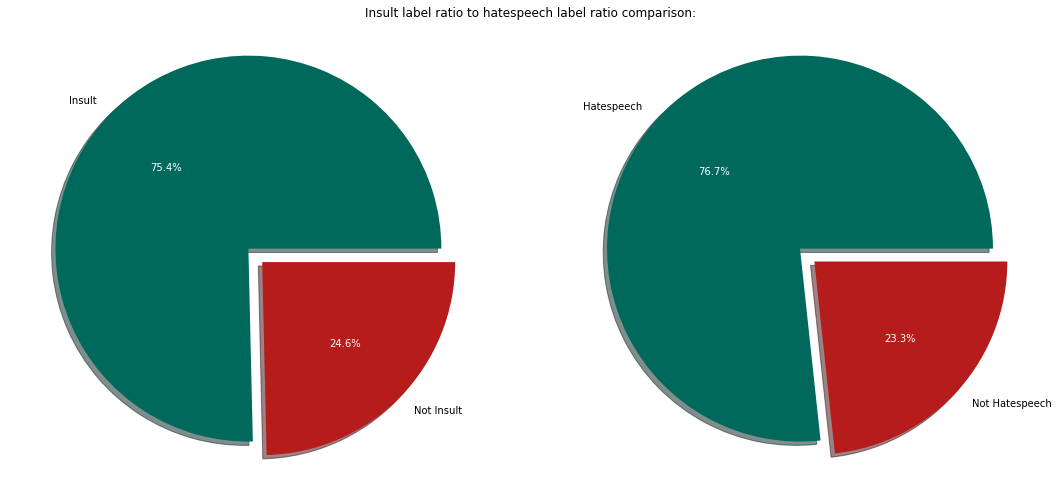

In [ ]:
import matplotlib.pyplot as plt
#define data
data = [len(combined_df[combined_df["Labels"] == 0])/len(combined_df),len(combined_df[combined_df["Labels"] == 1])/len(combined_df)]
data2 = [len(combined_df[combined_df["HS_Label"] == 0])/len(combined_df), len(combined_df[combined_df["HS_Label"] == 1])/len(combined_df)]
labels = ['Insult', 'Not Insult']
labels2 = ['Hatespeech', "Not Hatespeech"]
plt.rcParams['font.size'] = 16.0
fig, ax = plt.subplots(1,2, figsize=(16,7))
_,_,autotexts0=ax[0].pie(data, labels=labels,colors=['#00695c','#b71c1c'],explode=(0, 0.1), autopct='%1.1f%%', shadow=True)
_,_,autotexts1=ax[1].pie(data2, labels=labels2, autopct='%1.1f%%',colors=['#00695c','#b71c1c'],explode=(0, 0.1), shadow=True)
for autotext in autotexts0:
    autotext.set_color('white')
for autotext in autotexts1:
    autotext.set_color('white')
plt.tight_layout()
fig.suptitle("Insult label ratio to hatespeech label ratio comparison:"); 

At first these results prove extremely promising, since the ratio's are extremely close.

In [ ]:
combined_df = combined_df.reset_index(drop=True)

def agreement_func():
    results = []
    for i in range(0, 23030):
        if combined_df["Labels"][i] == 1 and combined_df["HS_Label"][i] == 1:
            results.append("Agree Hatespeech")
        elif combined_df["Labels"][i] == 0 and combined_df["HS_Label"][i] == 0:
            results.append("Agree Not Hatespeech")
        elif combined_df["Labels"][i] == 1 and combined_df["HS_Label"][i] == 0:
            results.append("False Negative")
        elif combined_df["Labels"][i] == 0 and combined_df["HS_Label"][i] == 1:
            results.append("False Positive")
    return results

combined_df["Agreement"] = agreement_func()
combined_df

,Labels,Tweets,HS_Label,Agreement
0,1,"Can you believe this fool, Dr. Thomas Frieden ...",0,False Negative
1,1,Big time in U.S. today - MAKE AMERICA GREAT AG...,1,Agree Hatespeech
2,1,Politician @SenatorCardin didn't like that I s...,0,False Negative
3,1,"For the nonbeliever, here is a photo of @Neily...",0,False Negative
4,1,".@Neilyoung’s song, “Rockin’ In The Free World...",0,False Negative
...,...,...,...,...
23025,0,RT @heatherjones333: 'We Have Taken Appropriat...,0,Agree Not Hatespeech
23026,0,RT @RandPaul: I don’t know why @JoeBiden think...,0,Agree Not Hatespeech
23027,0,RT @EliseStefanik: President @realDonaldTrump ...,0,Agree Not Hatespeech
23028,0,RT @TeamTrump: LIVE: Presidential Debate #Deba...,0,Agree Not Hatespeech


In [ ]:
combined_df.to_csv("/work/twitter-nlp/streamlit/data/trump_agreement.csv")

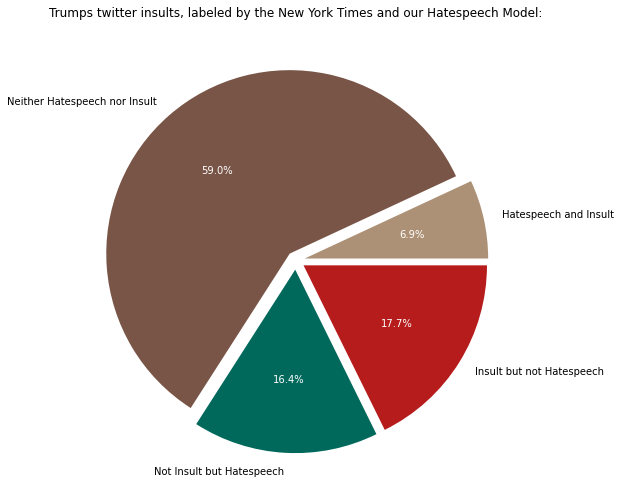

In [ ]:
agreement_ratio = [
    len(combined_df[combined_df["Agreement"] == "Agree Hatespeech"])/len(combined_df),
    len(combined_df[combined_df["Agreement"] == "Agree Not Hatespeech"])/len(combined_df), 
    len(combined_df[combined_df["Agreement"] == "False Positive"])/len(combined_df), 
    len(combined_df[combined_df["Agreement"] == "False Negative"])/len(combined_df)
    ]

fig, ax = plt.subplots(figsize=(16,7))
_,_,autotexts=ax.pie(agreement_ratio, 
labels = [
    "Hatespeech and Insult", 
    "Neither Hatespeech nor Insult", 
    "Not Insult but Hatespeech", 
    "Insult but not Hatespeech"
    ],
    colors=['#ad9176', '#795548', '#00695c','#b71c1c'],
    explode=(0.05,0.05,0.05,0.05), 
    autopct='%1.1f%%'
    )

for autotext in autotexts:
    autotext.set_color('white')
fig.suptitle("Trumps twitter insults, labeled by the New York Times and our Hatespeech Model:")
plt.tight_layout()

However after comparing the labeling of each tweet, one can see that our model only agree's with the trump insult labeling around two thirds of the time. <br>
This is not necessarily a bad thing however. An insult is not necessarily hatespeech, and vice versa. <br>

But we can still conclude the following interesting facts from these results:
- 7% of all of Trumps tweets which were insults, were also hatespeech according to our model.
- 23,3% of all of Trumps tweets (including insult tweets), were hatespeech according to our model.

In connection with the model we can also say that around 66% of the time both the labeling of the hatespeech, and our Hatespeech model labeling, agree.

## Testing our classifier on the offensive tweets dataset

We decided to also run a test on the offensive tweets dataset, which was provided alongside our hate speech dataset: 
> https://github.com/cardiffnlp/tweeteval

This dataset is based on the OLID dataset. The dataset's source was not necesarrily the reasoning for pitting it against our model, but more so since it we were interested in seeing how offensiveness and hatespeech would correlate, and how our model would react in this case.

In [ ]:
# loading the data:
def load_file(file):
    with open(file, mode='r') as f:
        data = f.readlines()
        data = [i.strip("\n") for i in data]
    return data

train_text = load_file("/work/twitter-nlp/data/tweeteval/datasets/offensive/train_text.txt")
train_labels = load_file("/work/twitter-nlp/data/tweeteval/datasets/offensive/train_labels.txt")
train_labels = [int(i) for i in train_labels]

OffenseDF = pd.DataFrame()
OffenseDF["Offense_Labels"] = train_labels
OffenseDF["Tweets"] = train_text

OffenseDF

,Offense_Labels,Tweets
0,0,@user Bono... who cares. Soon people will unde...
1,1,@user Eight years the republicans denied obama...
2,0,@user Get him some line help. He is gonna be j...
3,0,@user @user She is great. Hi Fiona!
4,1,@user She has become a parody unto herself? Sh...
...,...,...
11911,1,@user I wonder if they are sex traffic victims?
11912,0,@user Do we dare say he is... better than Nyjer?
11913,0,@user No idea who he is. Sorry
11914,0,#Professor Who Shot Self Over Trump Says Gun C...


In [ ]:
# offense_prediction = predict_list(OffenseDF["Tweets"])

In [ ]:
# pickling(offense_prediction, "/work/twitter-nlp/data/pickle/classification_pickles/OffensePrediction.pkl")

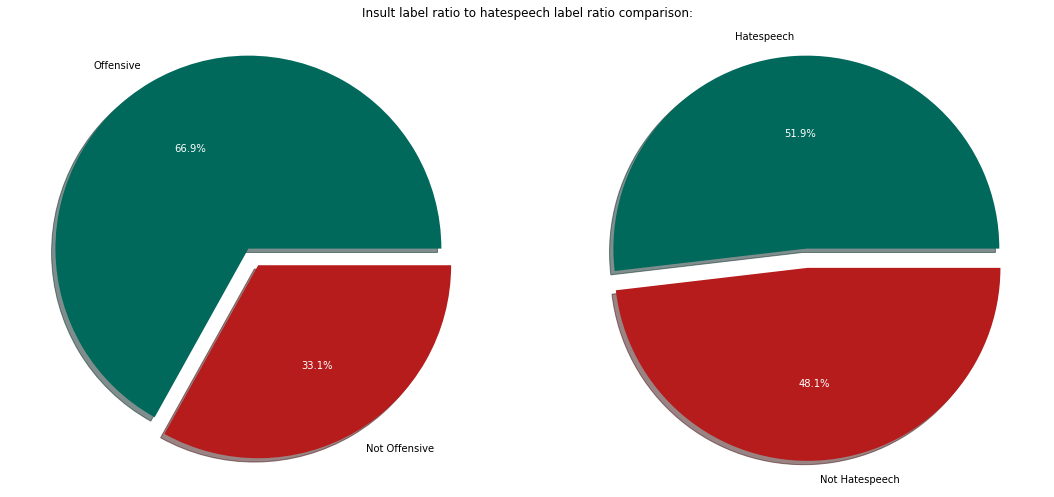

In [ ]:
offense_predict = open_jar("/work/twitter-nlp/data/pickle/classification_pickles/OffensePrediction.pkl")
OffenseDF["HS_Label"] = label_predictions(offense_predict)

import matplotlib.pyplot as plt
#define data
data = [len(OffenseDF[OffenseDF["Offense_Labels"] == 0])/len(OffenseDF),len(OffenseDF[OffenseDF["Offense_Labels"] == 1])/len(OffenseDF)]
data2 = [len(OffenseDF[OffenseDF["HS_Label"] == 0])/len(OffenseDF), len(OffenseDF[OffenseDF["HS_Label"] == 1])/len(OffenseDF)]
labels = ['Offensive', 'Not Offensive']
labels2 = ['Hatespeech', "Not Hatespeech"]

fig, ax = plt.subplots(1,2, figsize=(16,7))
_,_,autotexts0=ax[0].pie(data, labels=labels, colors=['#00695c','#b71c1c'],explode=(0, 0.1), autopct='%1.1f%%', shadow=True)
_,_,autotexts1=ax[1].pie(data2, labels=labels2, autopct='%1.1f%%',colors=['#00695c','#b71c1c'],explode=(0, 0.1), shadow=True)
for autotext in autotexts0:
    autotext.set_color('white')
for autotext in autotexts1:
    autotext.set_color('white')
plt.tight_layout()
fig.suptitle("Insult label ratio to hatespeech label ratio comparison:"); 

In this case, the labelling do not seem to agree purely based on the ratio.

In [ ]:
OffenseDF = OffenseDF.reset_index(drop=True)

def agreement_func():
    results = []
    for i in range(0, 11916):
        if OffenseDF["Offense_Labels"][i] == 1 and  OffenseDF["HS_Label"][i] == 1:
            results.append("Agree Offense")
        elif OffenseDF["Offense_Labels"][i] == 0 and  OffenseDF["HS_Label"][i] == 0:
            results.append("Agree Not Offense")
        elif OffenseDF["Offense_Labels"][i] == 1 and OffenseDF["HS_Label"][i] == 0:
            results.append("False Negative")
        elif OffenseDF["Offense_Labels"][i] == 0 and OffenseDF["HS_Label"][i] == 1:
            results.append("False Positive")
    return results

OffenseDF["Agreement"] = agreement_func()
OffenseDF

,Offense_Labels,Tweets,HS_Label,Agreement
0,0,@user Bono... who cares. Soon people will unde...,0,Agree Not Offense
1,1,@user Eight years the republicans denied obama...,0,False Negative
2,0,@user Get him some line help. He is gonna be j...,0,Agree Not Offense
3,0,@user @user She is great. Hi Fiona!,1,False Positive
4,1,@user She has become a parody unto herself? Sh...,1,Agree Offense
...,...,...,...,...
11911,1,@user I wonder if they are sex traffic victims?,0,False Negative
11912,0,@user Do we dare say he is... better than Nyjer?,0,Agree Not Offense
11913,0,@user No idea who he is. Sorry,1,False Positive
11914,0,#Professor Who Shot Self Over Trump Says Gun C...,0,Agree Not Offense


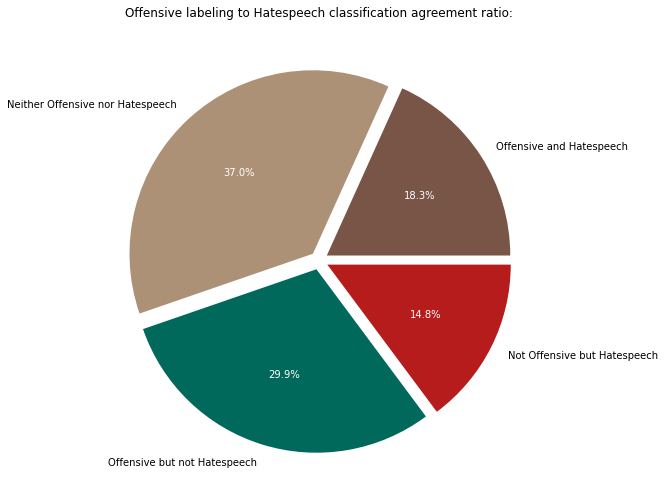

In [ ]:
agreement_ratio = [
    len(OffenseDF[OffenseDF["Agreement"] == "Agree Offense"])/len(OffenseDF),
    len(OffenseDF[OffenseDF["Agreement"] == "Agree Not Offense"])/len(OffenseDF), 
    len(OffenseDF[OffenseDF["Agreement"] == "False Positive"])/len(OffenseDF), 
    len(OffenseDF[OffenseDF["Agreement"] == "False Negative"])/len(OffenseDF)
    ]
fig, ax = plt.subplots(figsize=(16,7))
_,_,autotexts=ax.pie(agreement_ratio, labels = ["Offensive and Hatespeech", "Neither Offensive nor Hatespeech", "Offensive but not Hatespeech", "Not Offensive but Hatespeech"],colors=['#795548','#ad9176','#00695c','#b71c1c'],explode=(0.05,0.05,0.05,0.05), autopct='%1.1f%%')
for autotext in autotexts:
    autotext.set_color('white')
fig.suptitle("Offensive labeling to Hatespeech classification agreement ratio:")
plt.tight_layout()

And it is of course even worse when looking at how each individual tweet is labeled. The ambition was however never to accurately classify offensive corpus. It can be argued that offensive tweets are not necesarrily always hatespeech. 

### Some more examples of how our model classifies:

In [ ]:
def classify_and_print(sentence):
    hatespeech_array = classify_sentence([sentence])
    print("Hatespeech Probability:", round(hatespeech_array[0][1], 2))
    print("Not Hatespeech Probability:", round(hatespeech_array[0][0], 2))

In [ ]:
classify_and_print("I fucking love pizza!")

AttributeError: 'list' object has no attribute 'lower'

In [ ]:
classify_and_print("Pizza is some fucking good food")

Hatespeech Probability: 0.22
Not Hatespeech Probability: 0.78


In [ ]:
classify_and_print("I would kill for a piece of pizza")

Hatespeech Probability: 0.44
Not Hatespeech Probability: 0.56


In [ ]:
classify_and_print("Fuck pizza, fucking hate immigrant food #buildthatwall")

Hatespeech Probability: 0.99
Not Hatespeech Probability: 0.01


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bf1f20fb-a6c0-4ea2-8567-a5a41eea1d8a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>